<a href="https://colab.research.google.com/github/MerkulovDaniil/optim/blob/master/assets/Notebooks/Newton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convergence issue

In [ ]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
sns.set()
plt.rcParams["animation.html"] = "html5"
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
import numpy as np


x_min, x_max = -1, 1
y_min, y_max = 0, 2
N_iter = 20
x_0 = 1

fig, ax = plt.subplots()
xdata = np.linspace(x_min,x_max)
ydata = xdata**4
plt.plot(xdata, ydata)
plt.xlabel(f'$x$')
plt.ylabel(f'$f(x) = x^4$')
line, = ax.plot([], [], marker='o', linestyle='-', color='r', label='Newton', lw=2)
plt.legend()
# ax.grid()
xdata, ydata = [x_0], [x_0**4]

def data_gen(t=0):
    cnt = 0
    x = x_0
    while cnt < N_iter:
        cnt += 1
        x = 2/3*x
        yield x

def init():
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    line.set_data(xdata, ydata)
    return line,

def run(data):
    # update the data
    x = data
    y = x**4
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
    return line,

ani = matplotlib.animation.FuncAnimation(fig, run, data_gen, blit=False, interval=1000,
                              repeat=True, init_func=init)

In [ ]:
ani

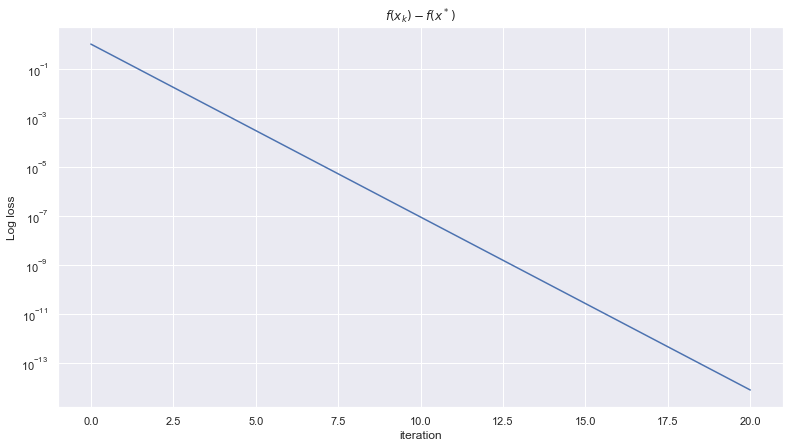

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
plt.semilogy(ydata)
plt.title(f'$f(x_k) - f(x^*)$')
plt.xlabel('iteration')
plt.ylabel('Log loss')
plt.show()

# Demonstration of local convergence

In [1]:
%%capture
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
plt.rcParams["animation.html"] = "html5"
from pylab import rcParams
rcParams['figure.figsize'] = 13, 7
import numpy as np

x_min, x_max = -3, 3
y_min, y_max = 1, 3
N_iter = 4
x_0 = 0.9



fig, ax = plt.subplots()
xdata = np.linspace(x_min,x_max)
ydata = np.sqrt(1 + xdata**2)
plt.plot(xdata, ydata)
plt.title(r'Newton method convergence for  $y = \sqrt{1 + x^2}$')
plt.xlabel(f'$x$')
plt.ylabel(f'$f(x)$')
line, = ax.plot([], [], marker='o', linestyle='-', color='r', label='Newton', lw=2)
plt.legend()
# ax.grid()
xdata, ydata = [x_0], [np.sqrt(1 + x_0**2)]

def data_gen(t=0):
    cnt = 0
    x = x_0
    while cnt < N_iter:
        cnt += 1
        x = -x**3
        yield x


def init():
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(x_min, x_max)
    line.set_data(xdata, ydata)
    return line,

def run(data):
    # update the data
    x = data
    y = np.sqrt(1 + x**2)
    xdata.append(x)
    ydata.append(y)
    line.set_data(xdata, ydata)
    return line,

ani = matplotlib.animation.FuncAnimation(fig, run, data_gen, blit=False, interval=1000,
                              repeat=True, init_func=init)

In [2]:
ani

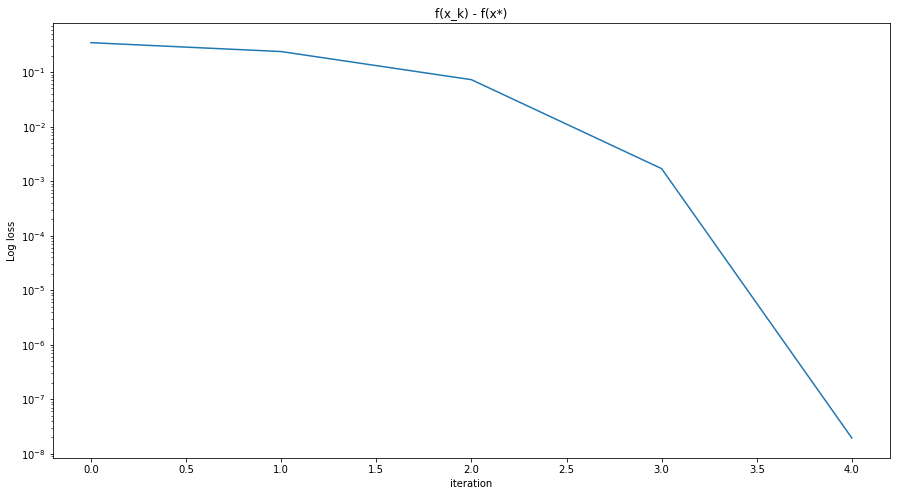

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
plt.semilogy(ydata - np.ones(len(ydata)))
plt.title('f(x_k) - f(x*)')
plt.xlabel('iteration')
plt.ylabel('Log loss')
plt.show()

Now try to change the starting point $x_0$ to $1.05$ 😀.

# Newton vs GD

[source](https://github.com/amkatrutsa/MIPT-Opt/tree/master/Spring2020)

In [5]:
import numpy as np

USE_COLAB = True
if USE_COLAB:
    !pip install git+https://github.com/amkatrutsa/liboptpy --quiet
        
import liboptpy.unconstr_solvers as methods
import liboptpy.step_size as ss

n = 1000
m = 200
x0 = np.zeros((n,))
A = np.random.rand(n, m) * 10

import cvxpy as cvx
x = cvx.Variable((n, 1))

obj = cvx.Minimize(cvx.sum(-cvx.log(1 - A.T * x)) - 
                   cvx.sum(cvx.log(1 - cvx.square(x))))
prob = cvx.Problem(obj)
prob.solve(verbose=True, max_iters=1000)
print("Optimal value =", prob.value)

Optimal value = -1368.795944194893


In [6]:
f = lambda x: -np.sum(np.log(1 - A.T.dot(x))) - np.sum(np.log(1 - x*x))
grad_f = lambda x: np.sum(A.dot(np.diagflat(1 / (1 - A.T.dot(x)))), axis=1) + 2 * x / (1 - np.power(x, 2))
hess_f = lambda x: (A.dot(np.diagflat(1 / (1 - A.T.dot(x))**2))).dot(A.T) + np.diagflat(2 * (1 + x**2) / (1 - x**2)**2)

In [7]:
def Newton(f, gradf, hessf, x0, epsilon, num_iter, line_search, 
                    disp=False, callback=None, **kwargs):
    x = x0.copy()
    iteration = 0
    opt_arg = {"f": f, "grad_f": gradf}
    for key in kwargs:
        opt_arg[key] = kwargs[key]
    while True:
        gradient = gradf(x)
        hess = hessf(x)
        h = np.linalg.solve(hess, -gradient)
        alpha = line_search(x, h, **opt_arg)
        x = x + alpha * h
        if callback is not None:
            callback(x)
        iteration += 1
        if disp:
            print("Current function val =", f(x))
            print("Current gradient norm = ", np.linalg.norm(gradf(x)))
        if np.linalg.norm(gradf(x)) < epsilon:
            break
        if iteration >= num_iter:
            break
    res = {"x": x, "num_iter": iteration, "tol": np.linalg.norm(gradf(x))}
    return res

In [8]:
newton = methods.so.NewtonMethod(f, grad_f, hess_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_newton = newton.solve(x0, tol=1e-6, max_iter=50, disp=True)

gd = methods.fo.GradientDescent(f, grad_f, ss.Backtracking("Armijo", rho=0.9, beta=0.1, init_alpha=1.))
x_gd = gd.solve(x0, tol=1e-6, max_iter=50, disp=True)

Required tolerance achieved!
Convergence in 14 iterations
Function value = -1368.79595248879
Norm of gradient = 7.716203171916831e-10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


Required tolerance achieved!
Convergence in 47 iterations
Function value = -1368.7959524887901
Norm of gradient = 5.152251827475411e-07


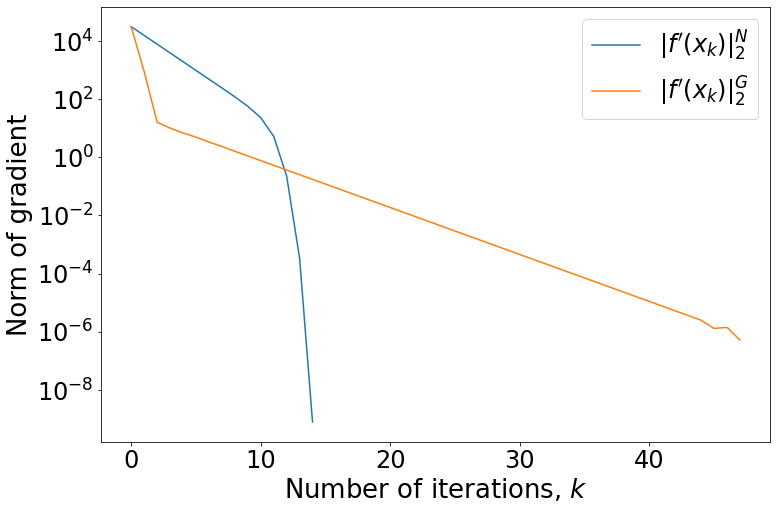

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

if not USE_COLAB:
    plt.rc("text", usetex=True)
    
plt.figure(figsize=(12, 8))
# Newton
plt.semilogy([np.linalg.norm(grad_f(x)) for x in newton.get_convergence()], label="$\| f'(x_k) \|^{N}_2$")
# Gradient
plt.semilogy([np.linalg.norm(grad_f(x)) for x in gd.get_convergence()], label="$\| f'(x_k) \|^{G}_2$")
plt.xlabel(r"Number of iterations, $k$", fontsize=26)
plt.ylabel(r"Norm of gradient", fontsize=26)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
plt.legend(loc="best", fontsize=24)
plt.show()